# Playground Series - S3E25

### Your Goal: For this Episode of the Series, your task is to use regression to predict the Mohs hardness of a mineral, given its properties. Good luck!

Evaluation metric: $ \( \text{MedAE}(y, \hat{y}) = \text{median}(|y_i - \hat{y}_i|, \ldots, |y_n - \hat{y}_n|) \) $

### Attempt 2:

Using some ideas from a submission from @msarvesh. I noticed zeros probably are equivalent to NaNs, and @msarvesh 
seems to be have implemented a solution imputes these values. I want to try using HistGradientBoostingRegressor with 
the NaN present (no imputer)



In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_predict, cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from sklearn.svm import SVR
import sweetviz as sv
import xgboost as xgb
import zipfile

from tools.eda_helper import eda_ols

In [31]:
# parameters
random_state=40
target_col = 'Hardness'

In [3]:
with zipfile.ZipFile('../../../res/data/playground-series-s3e25.zip', 'r') as z:
    
    with z.open('train.csv') as f:
        train= pd.read_csv(f,)        
                
    with z.open('test.csv') as f:
        test = pd.read_csv(f,)

## EDA

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



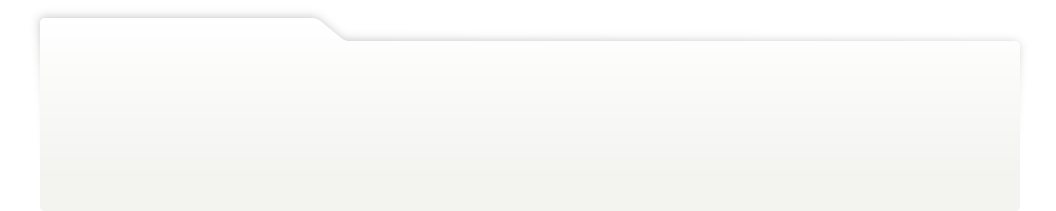
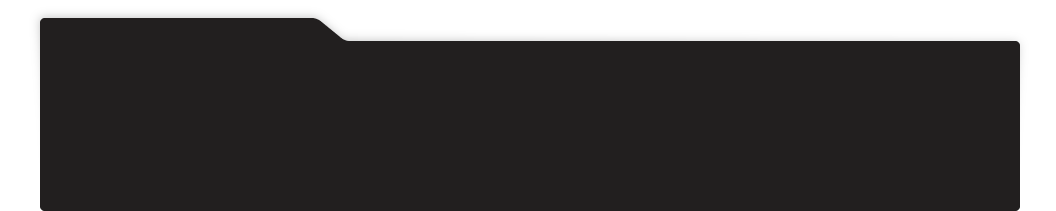
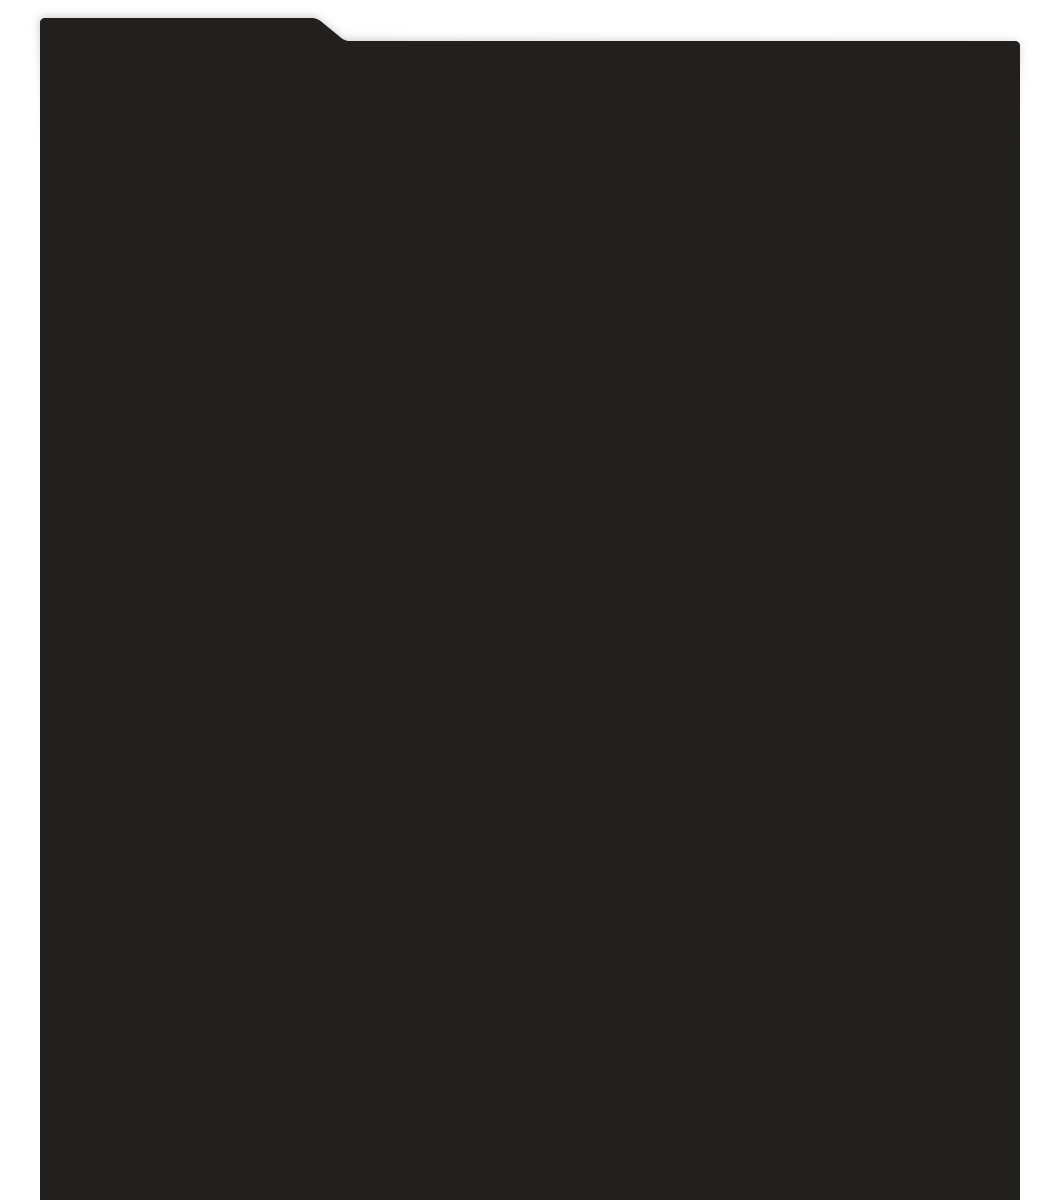
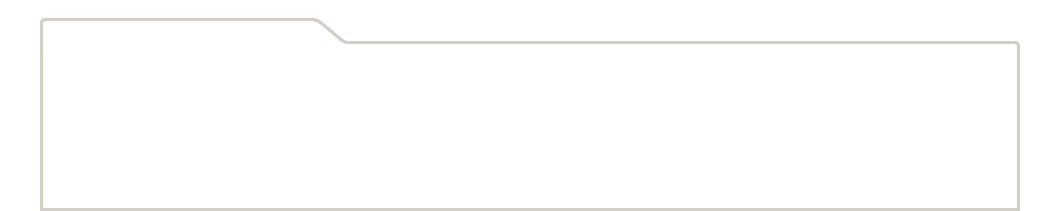
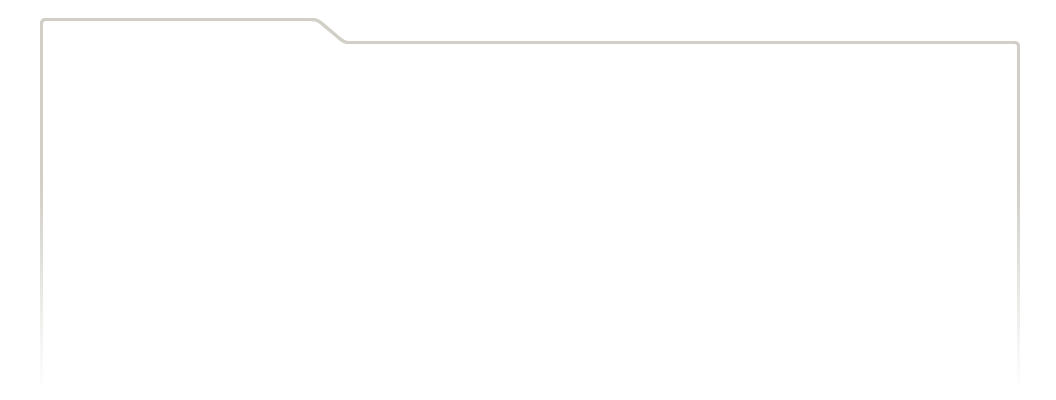
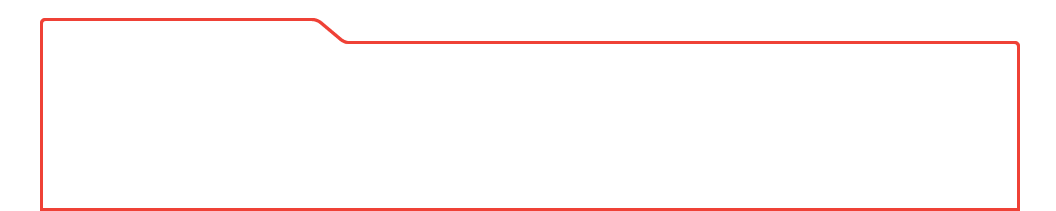
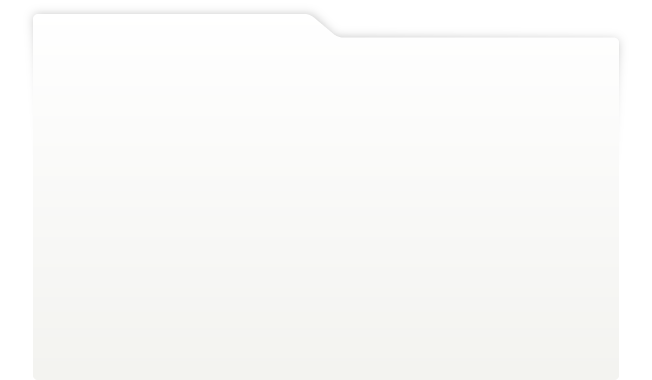
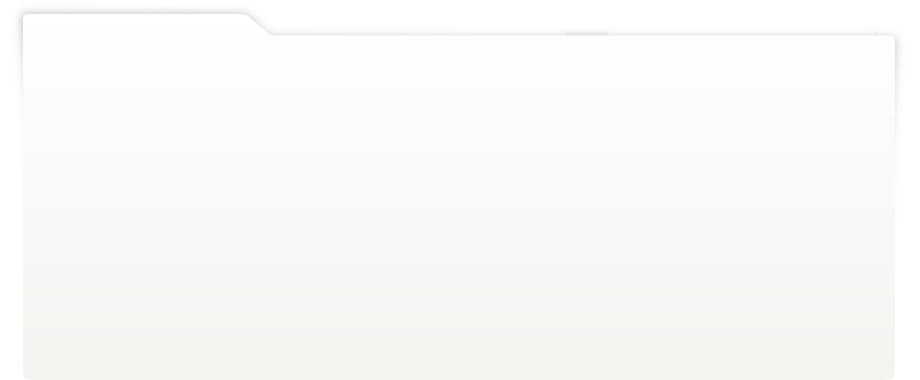
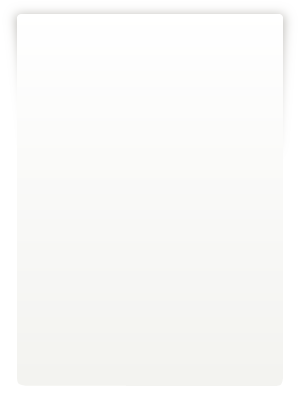
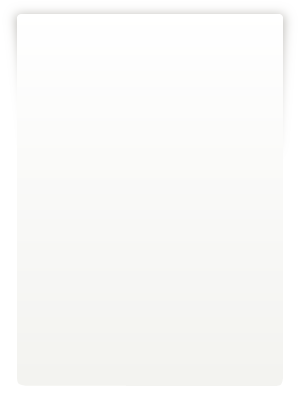
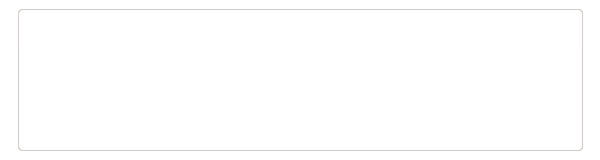
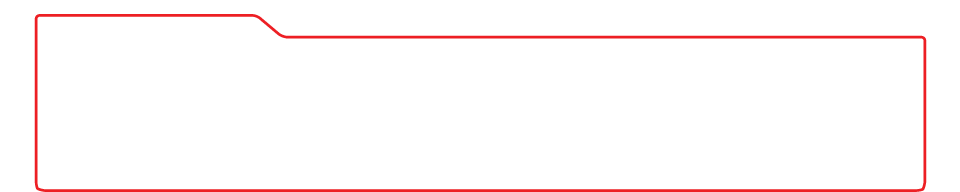
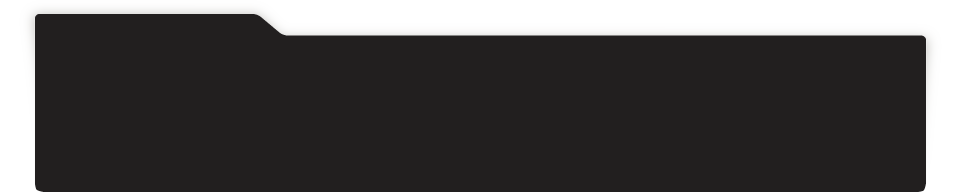
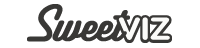
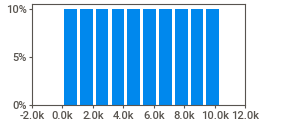
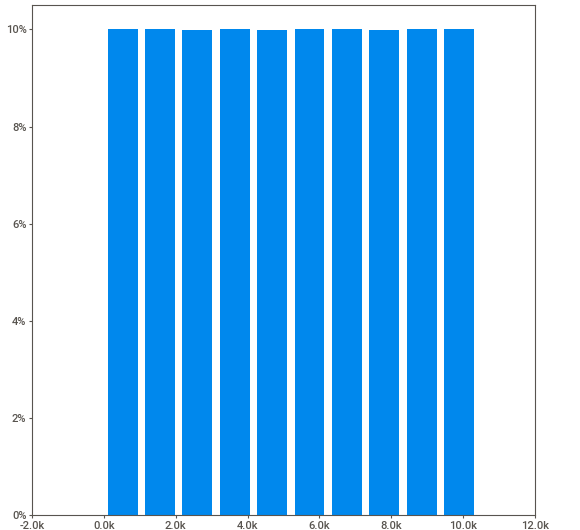
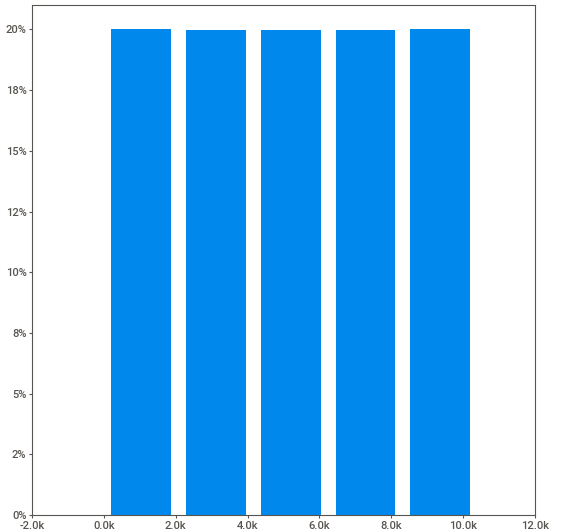
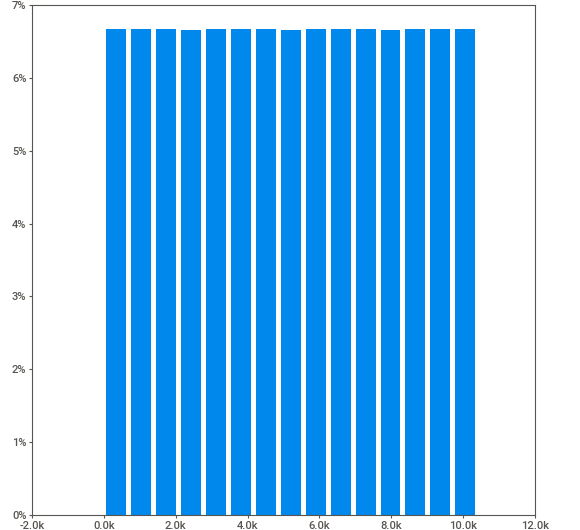
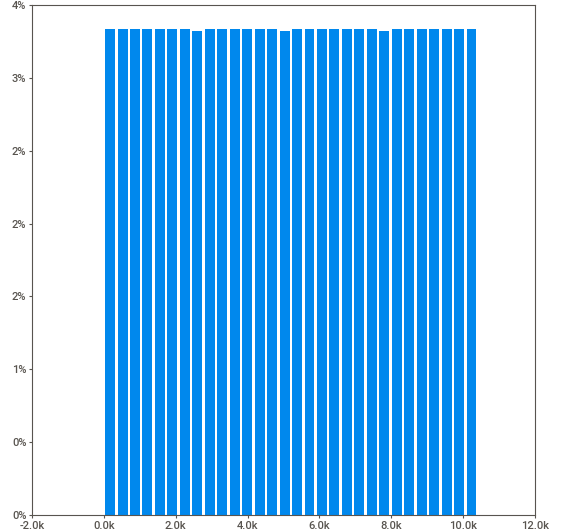
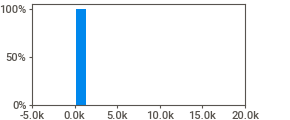
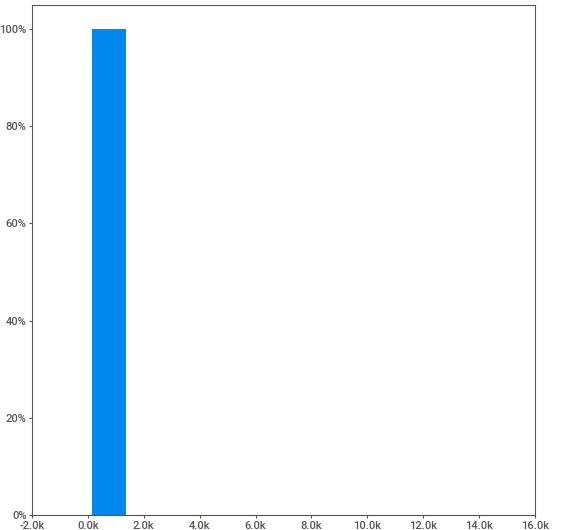
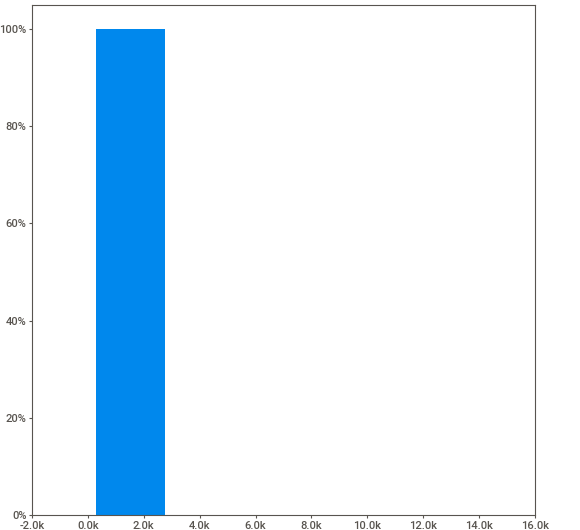
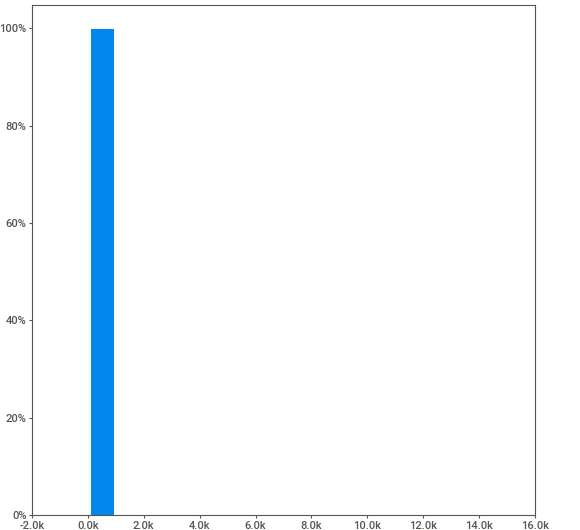
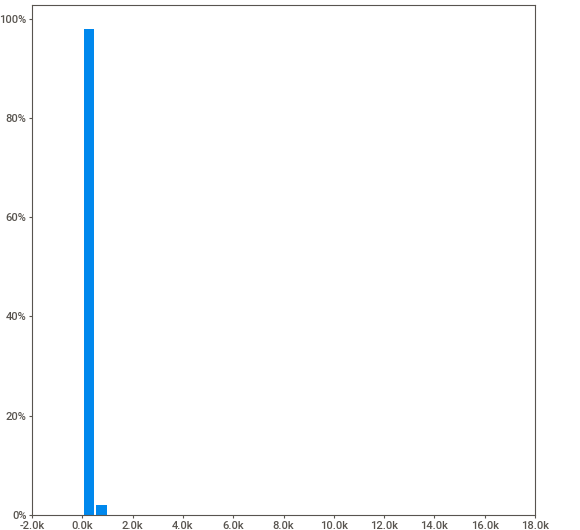
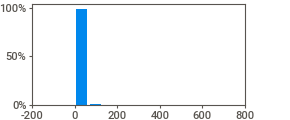
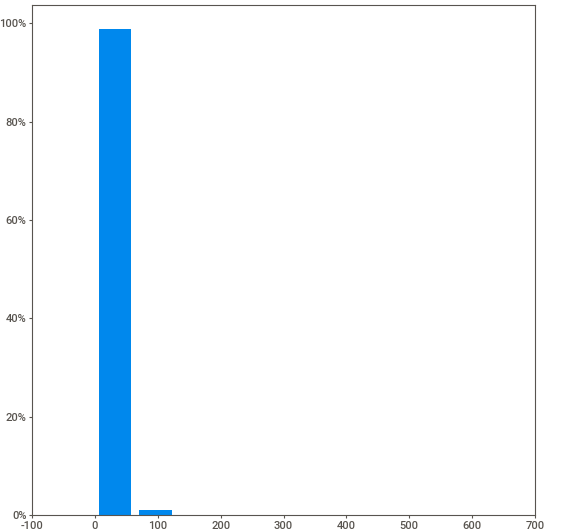
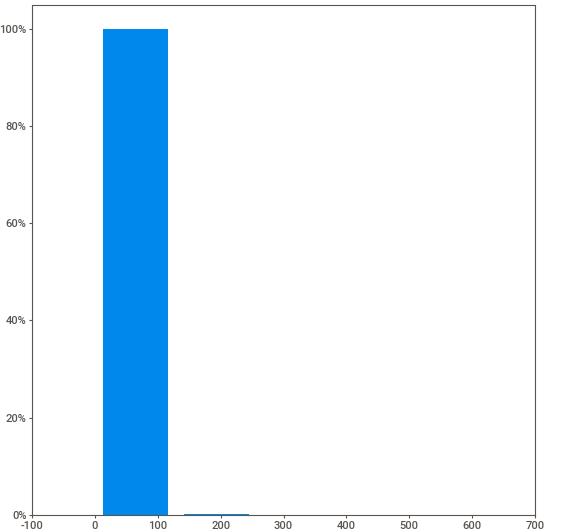
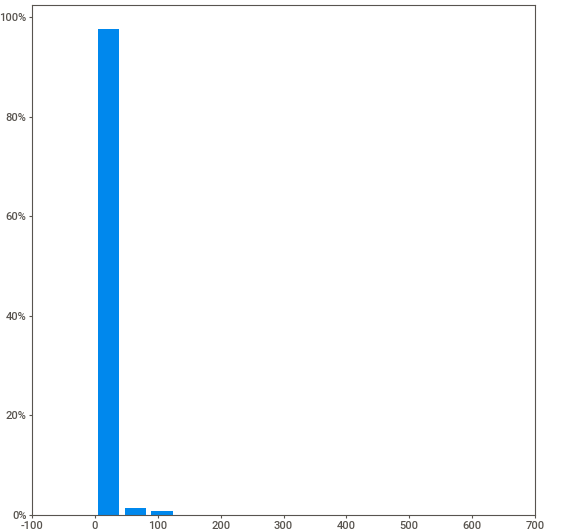
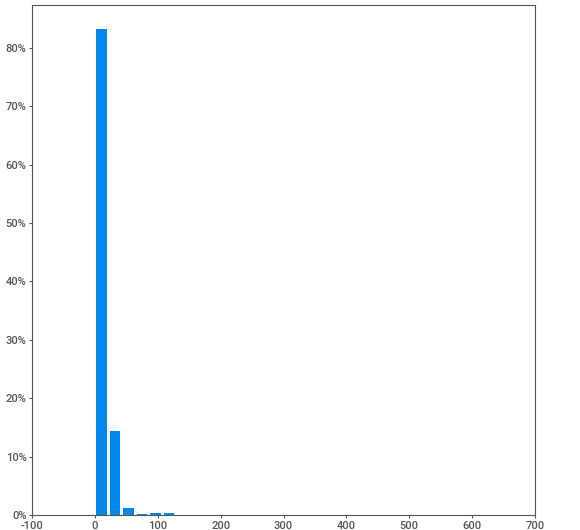
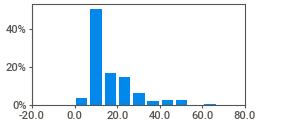
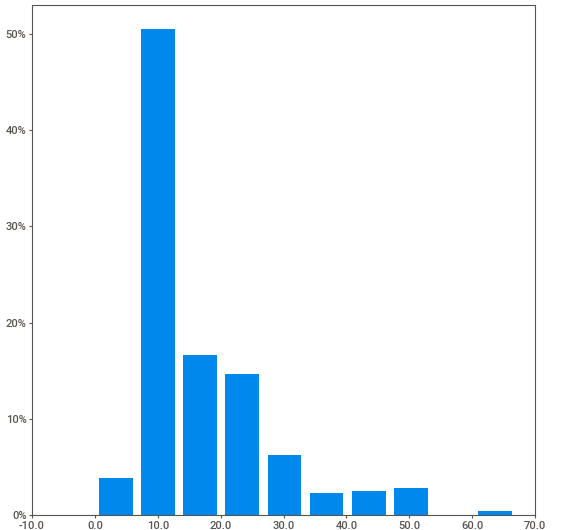
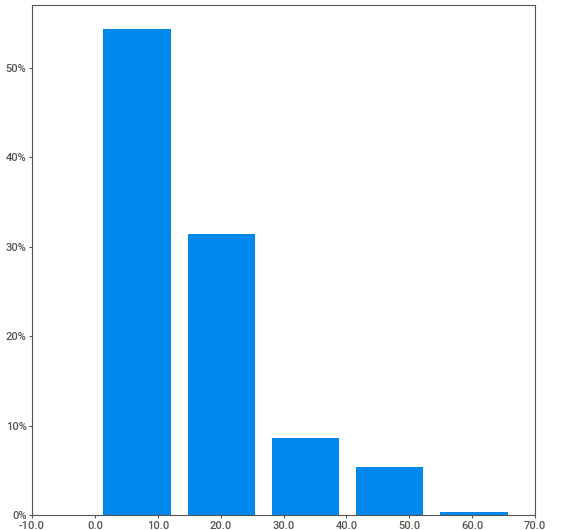
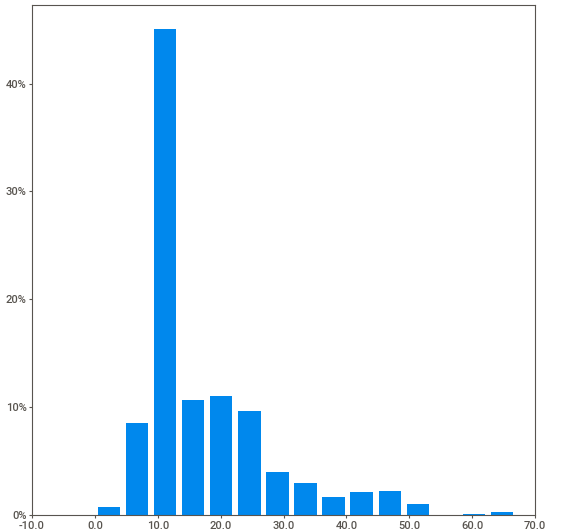
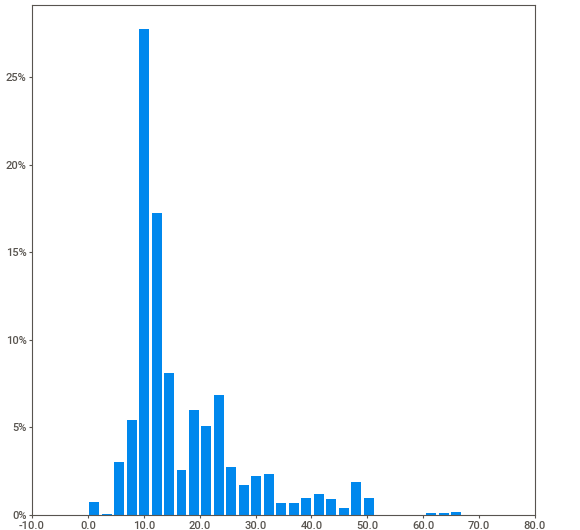
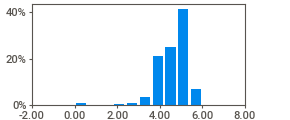
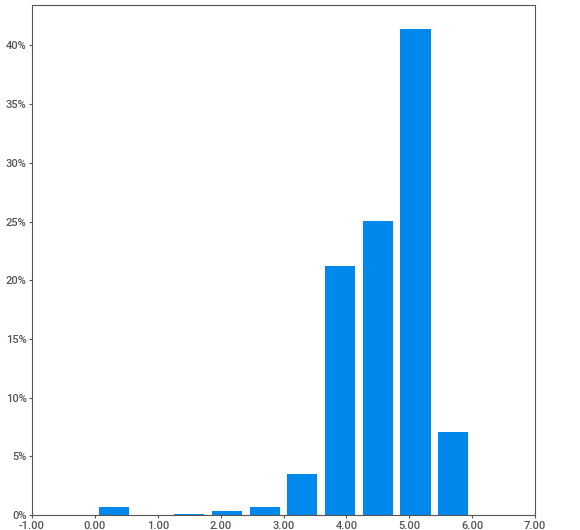
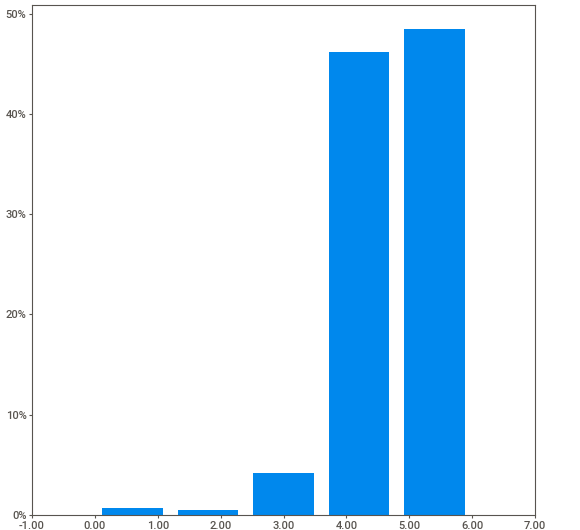
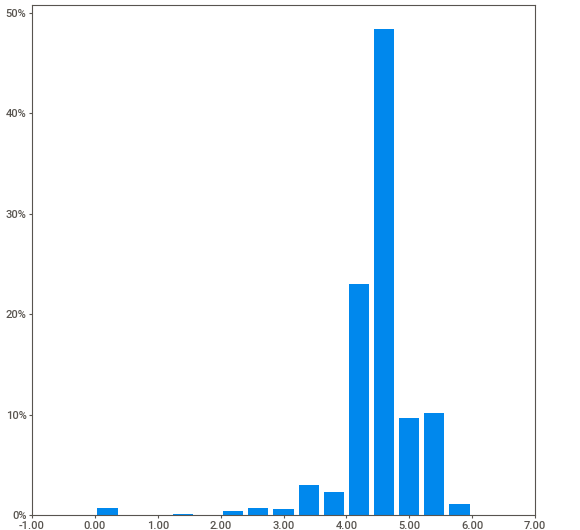
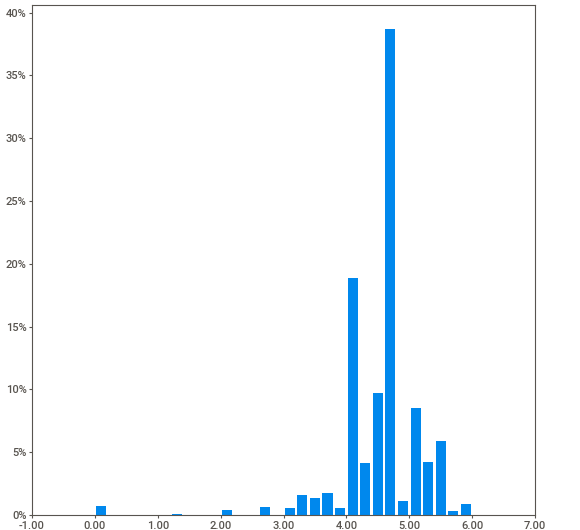
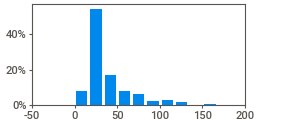
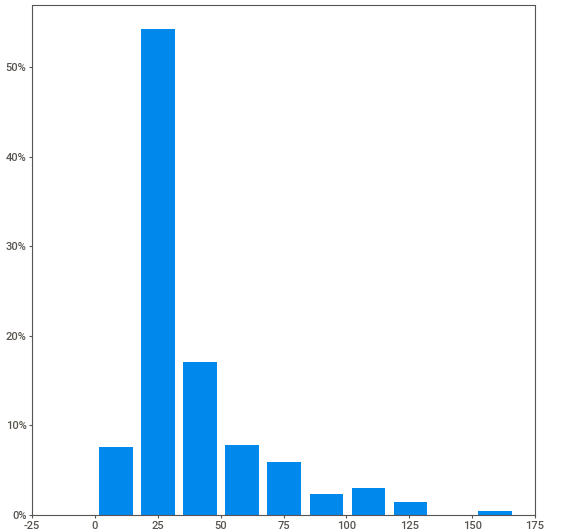
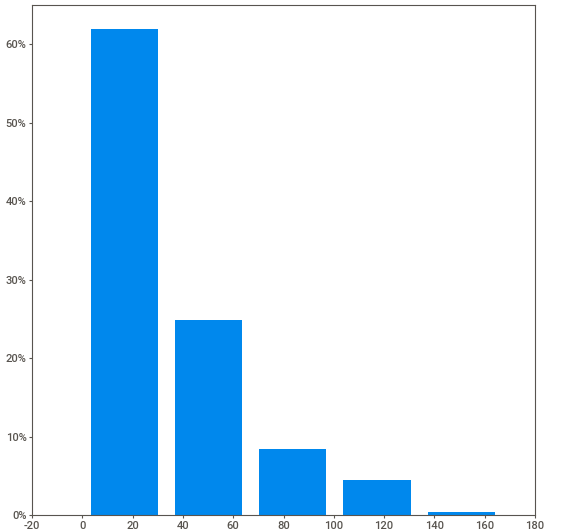
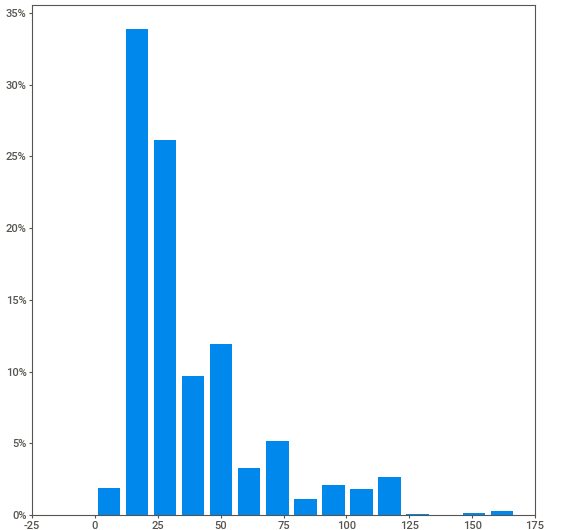
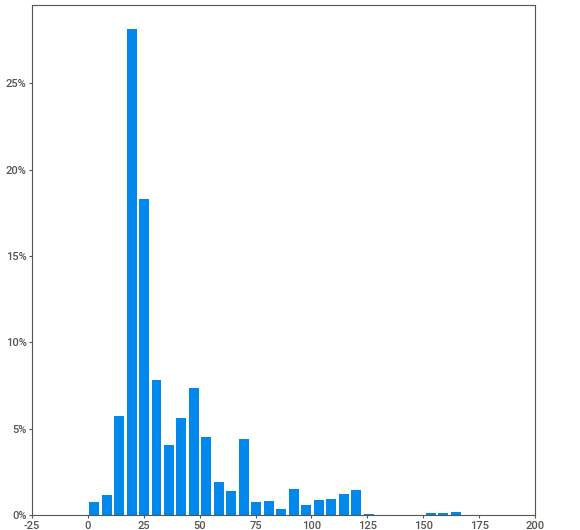
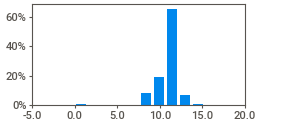
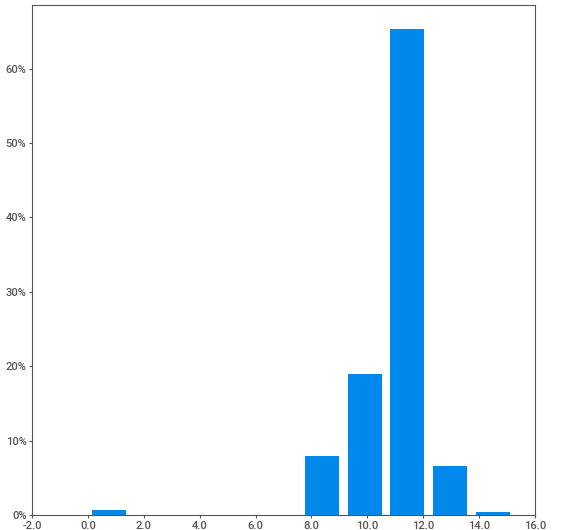
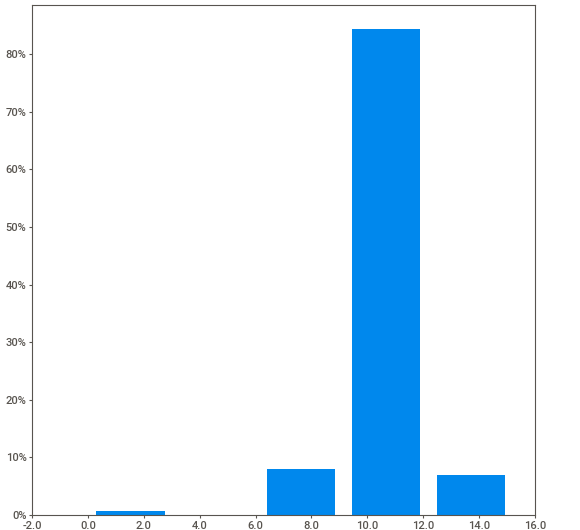
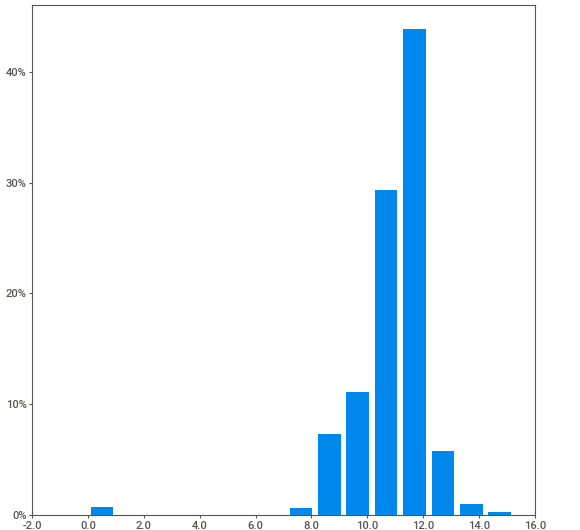
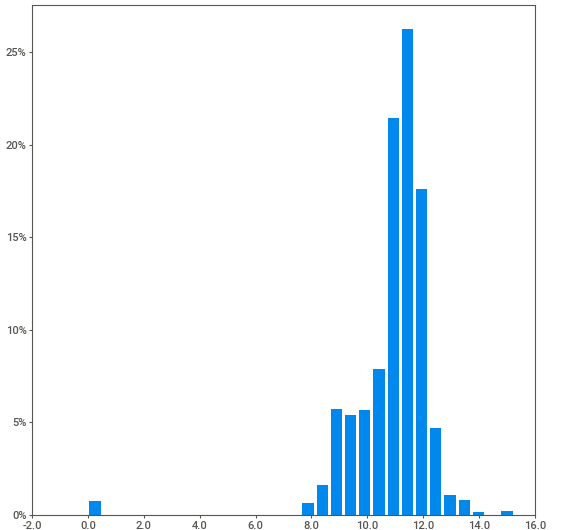
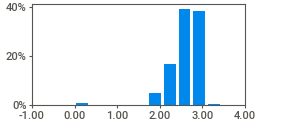
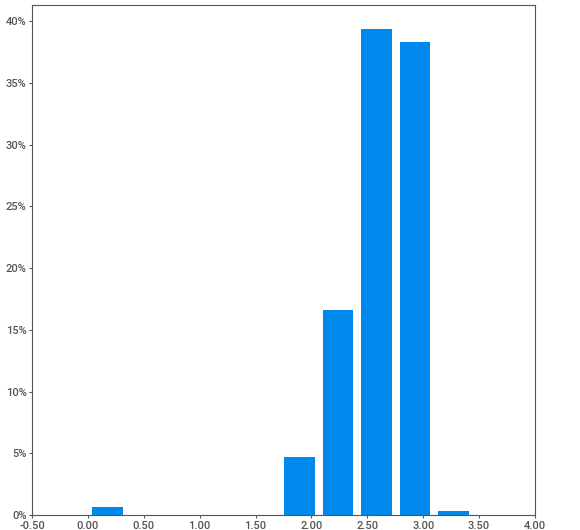
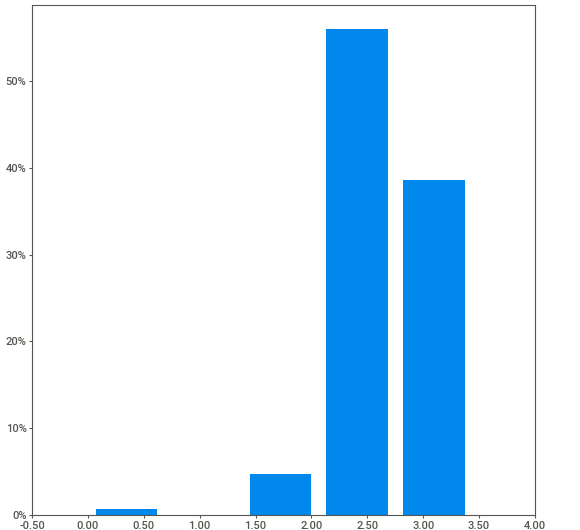
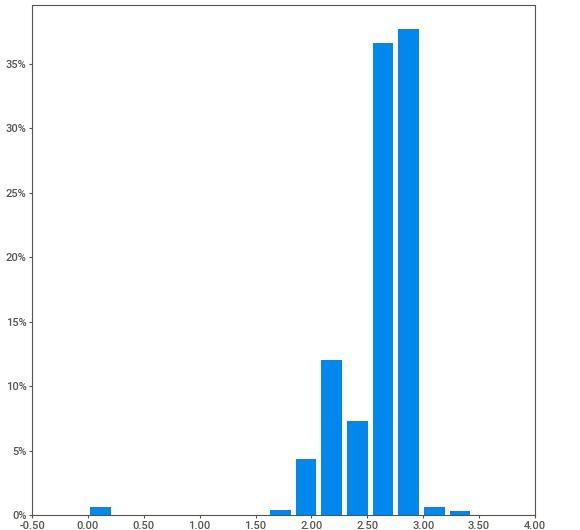
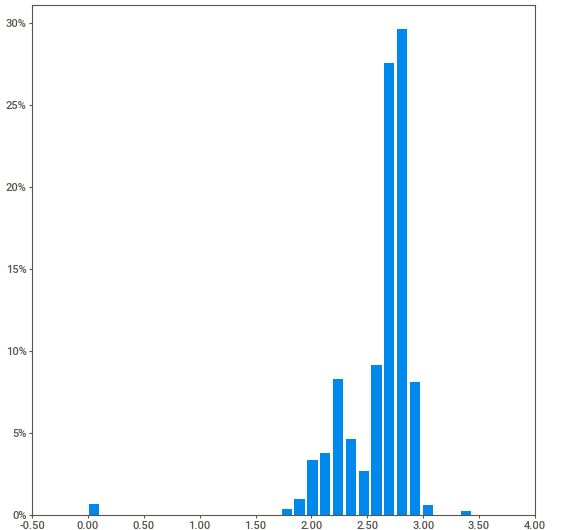
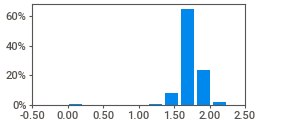
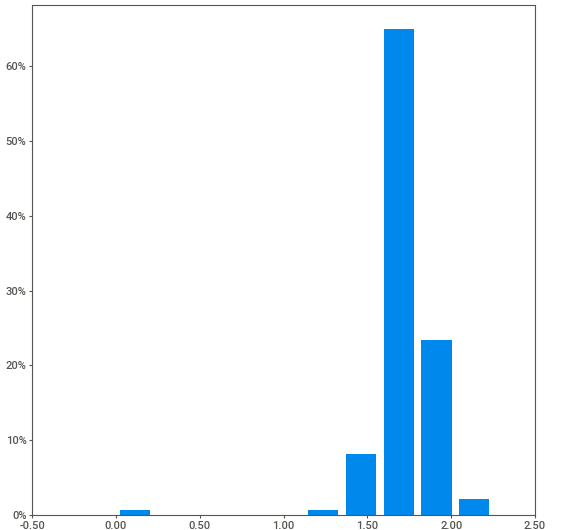
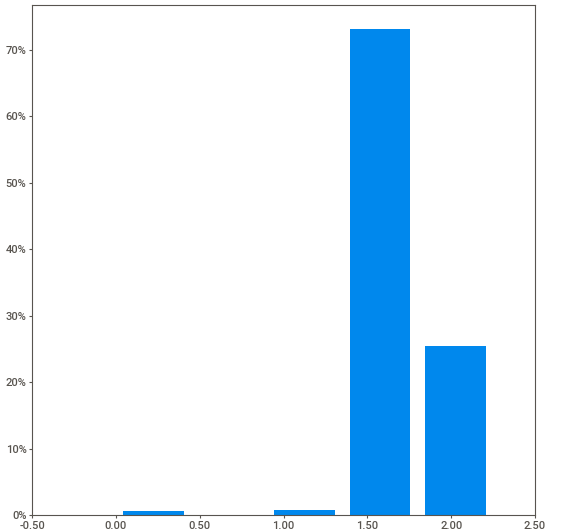
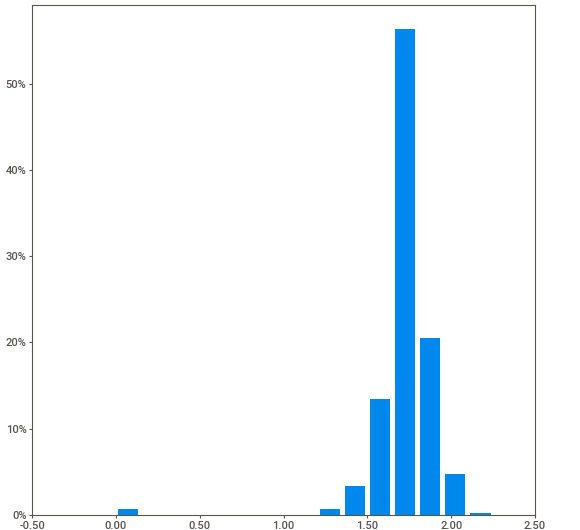
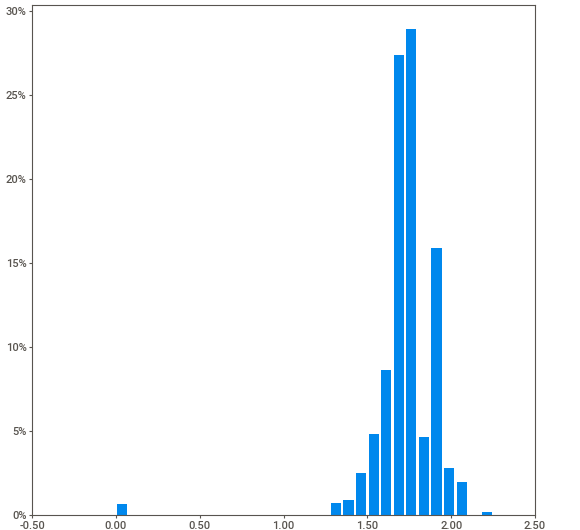
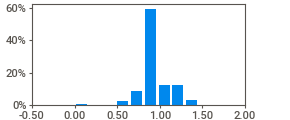
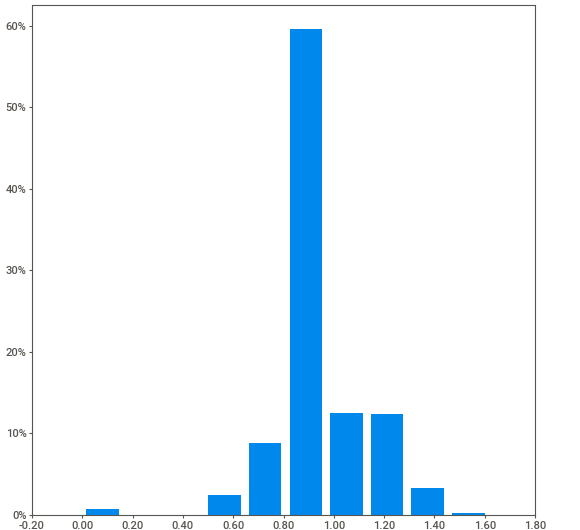
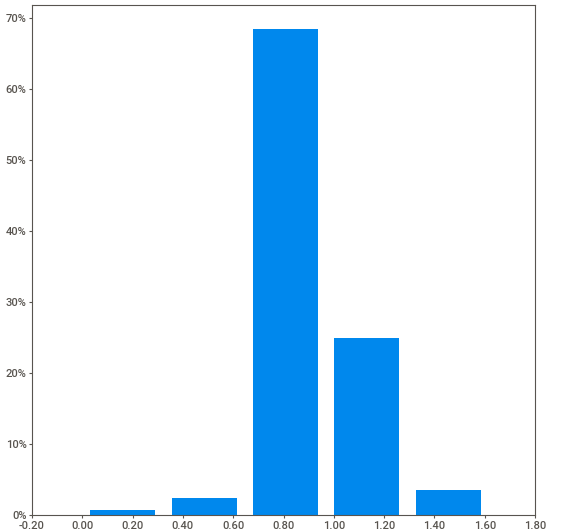
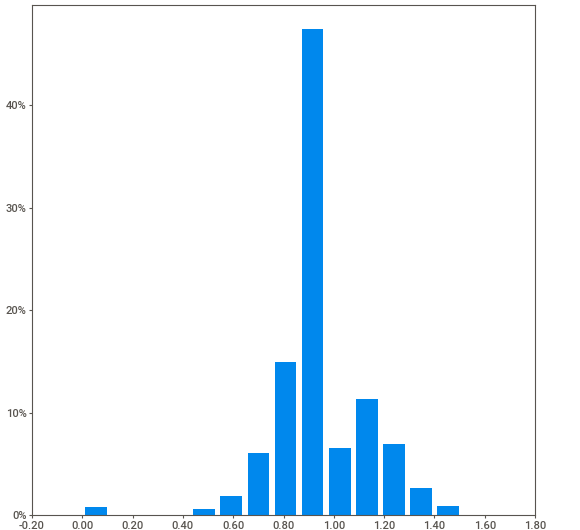
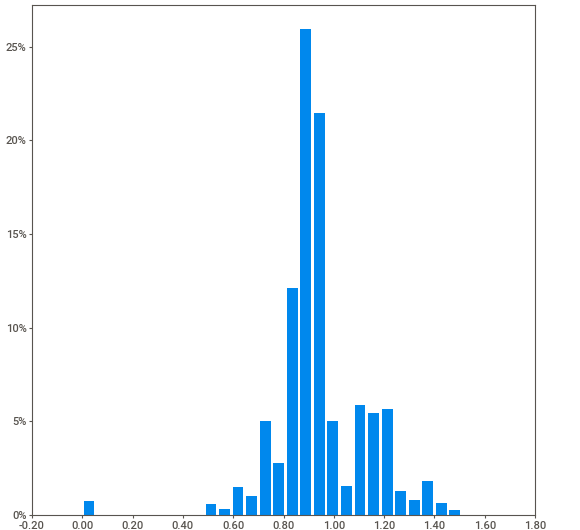
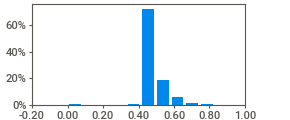
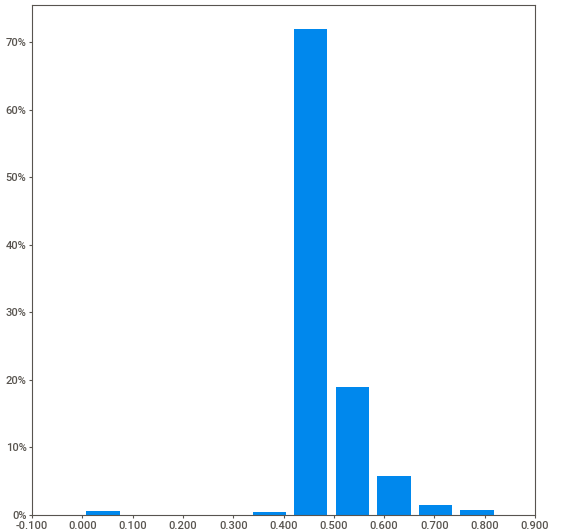
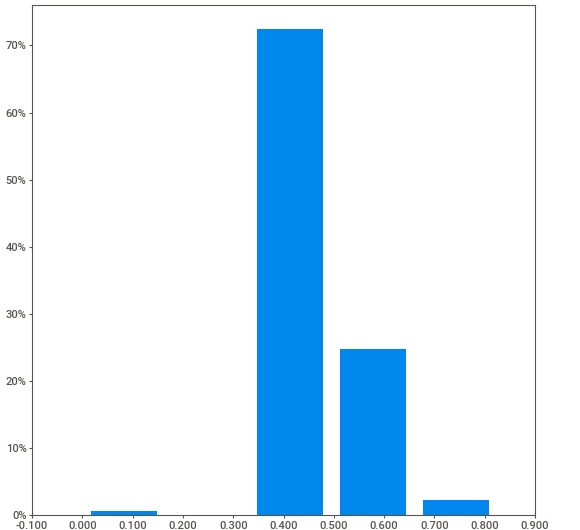
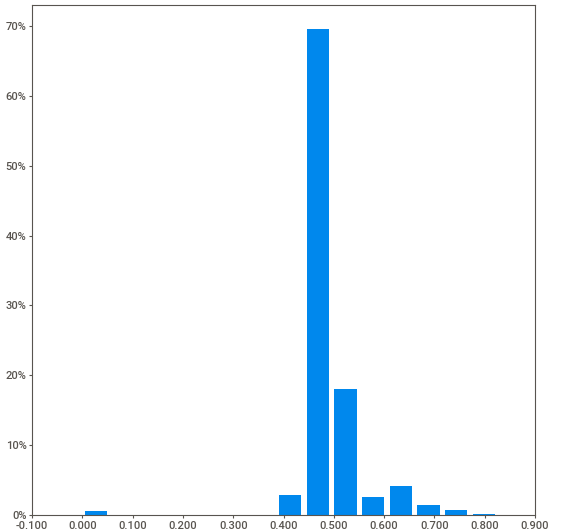
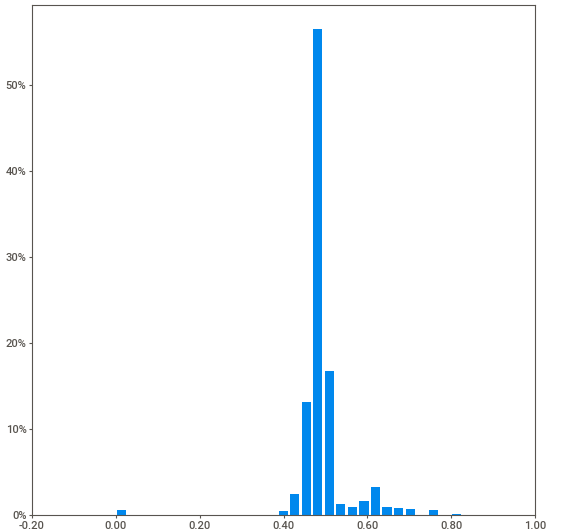
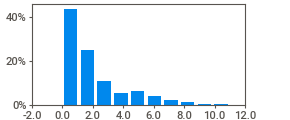
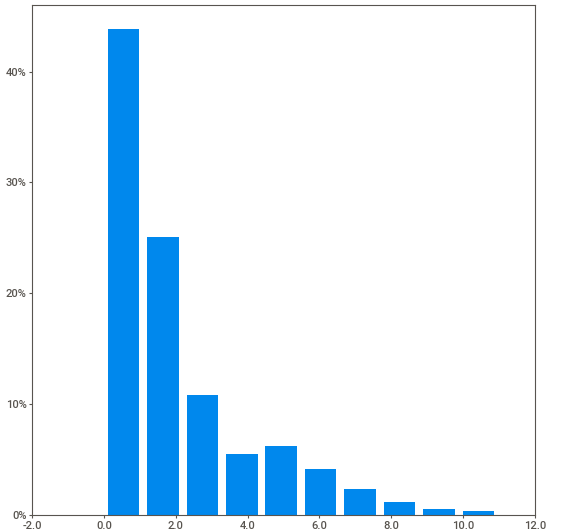
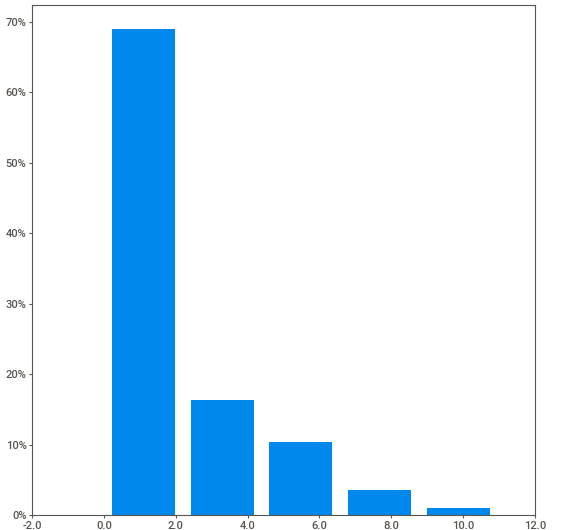
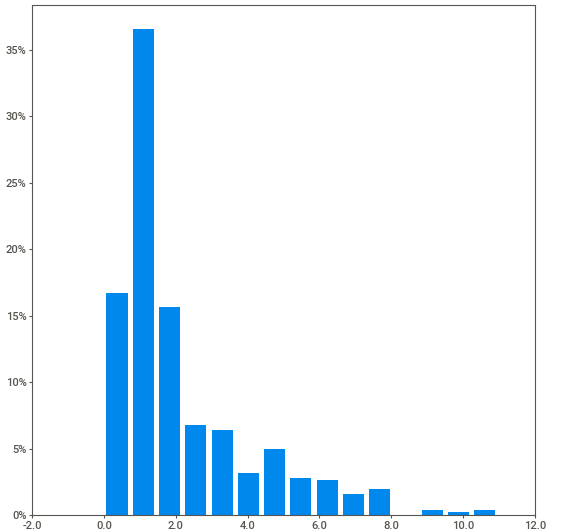
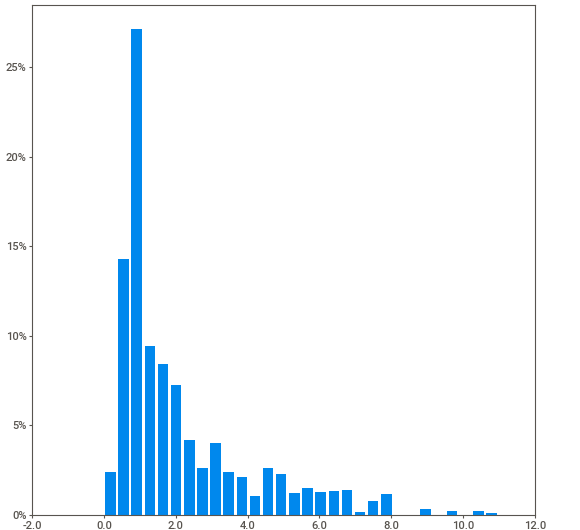
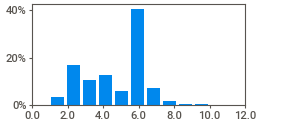
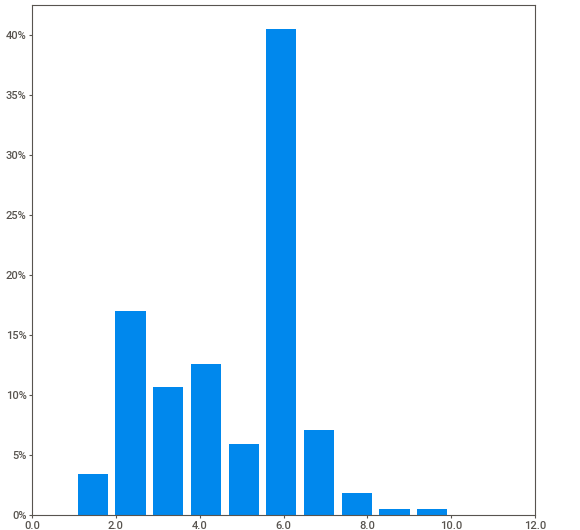
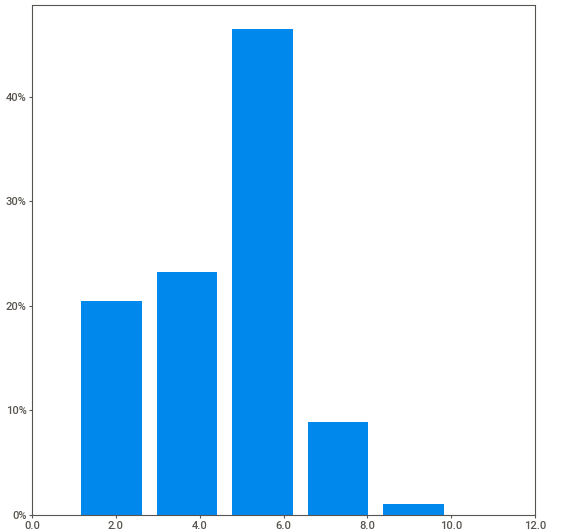
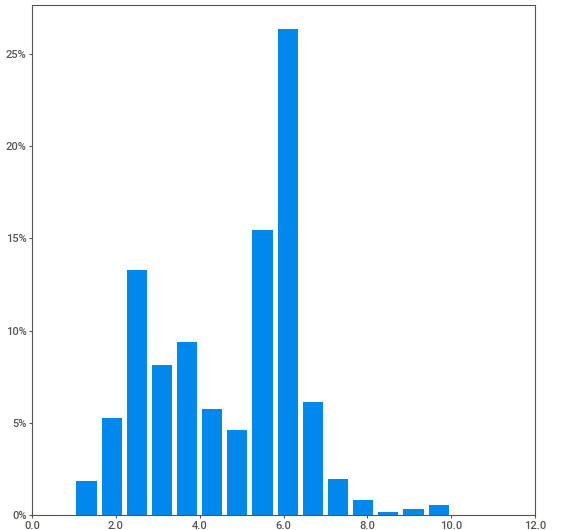
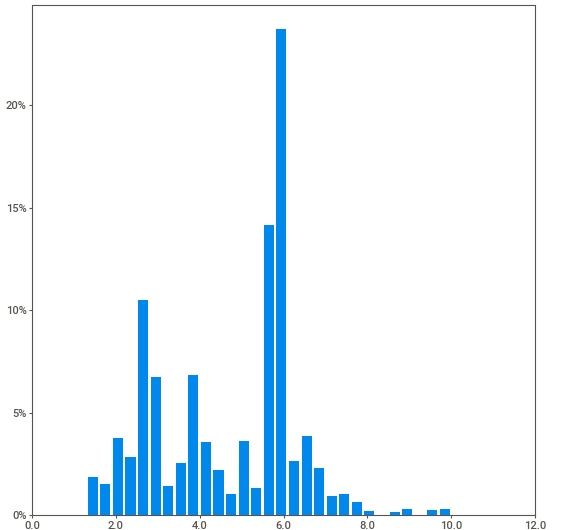
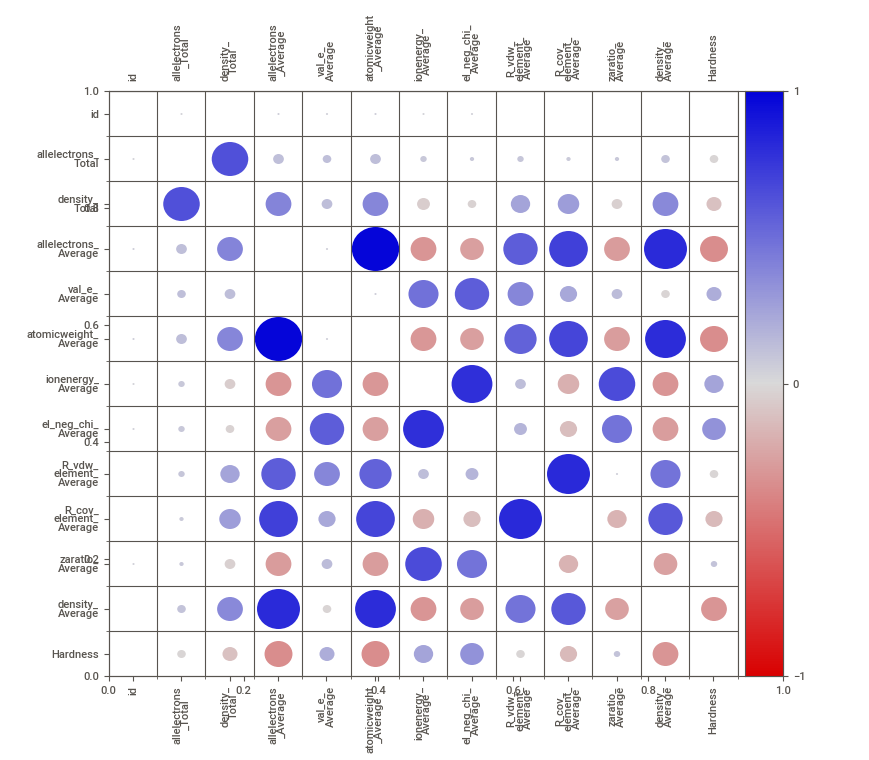
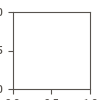

In [4]:
my_report = sv.analyze(train)
my_report.show_html()
my_report.show_notebook()

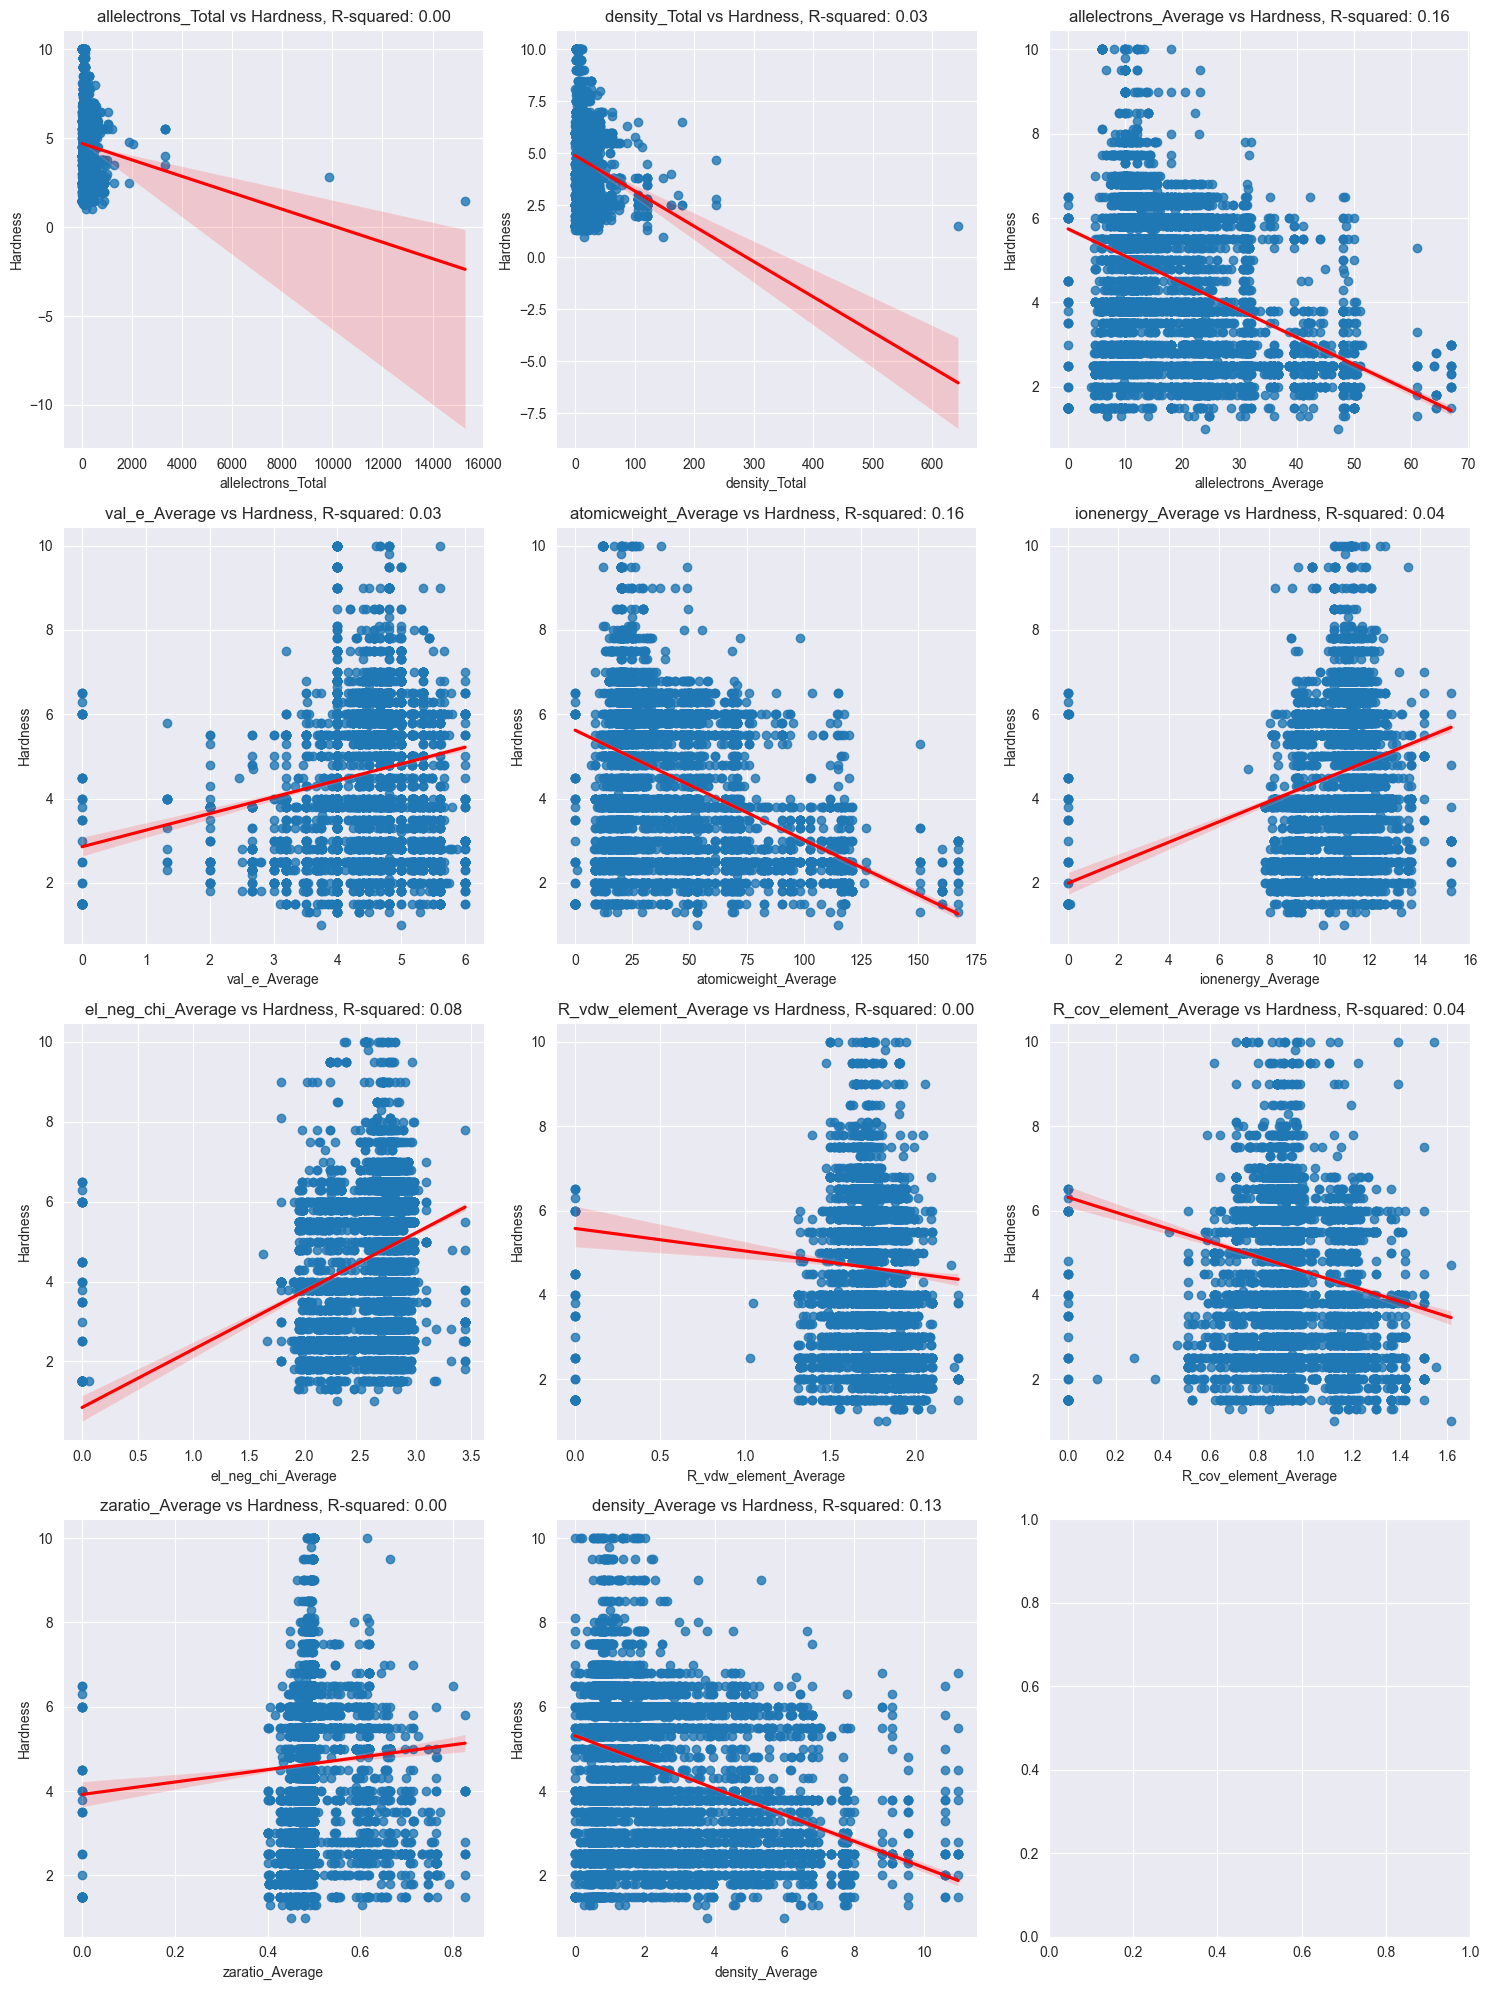

In [4]:
eda_ols(train.drop('id', axis=1), target_col)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
train.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


## EDA Insights

- 12 (11 + 1 target) numerical features in dataset, none are categorical. `id` is not of use in training set.
- No missing data, but zeros seem like missing data.

### feature observations
- `allelectrons_Total` and `density_Total` highly positive skew with significant peakedness. Mode concentration is 
high compared to range of data. Outliers present.
- Significant negative Pearson correlation for hardness: ['allelectrons_Average', 'atomicweight_Average', 
'density_Average']
- Significant positive Pearson correlation for hardness: ['el_neg_chi_Average', 'ionenergy_Average']

## Feature Engineering

In [32]:
log_feature_names = ['allelectrons_Total', 'density_Total']

def log_transform(x):
    return np.log1p(x)  # Applies log(1+x) to the input

log_transformer_func = FunctionTransformer(log_transform)
# Create the ColumnTransformer
log_transformer = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer_func, log_feature_names)
    ],
    remainder='passthrough'  # This will pass through the other columns untouched
)

def zero_transform(X):
        # Convert zeros to np.nan
        X_modified = np.where(X == 0, np.nan, X)
        return X_modified

zero_transformer_func = FunctionTransformer(zero_transform)


In [52]:

X = train[[col for col in train.columns if col not in  [target_col, 'id']]]
y = train[target_col]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


## Initial Approach: Linear Regression
Determine a baseline for error using a basic regression technique 

In [148]:
hgb_params = {
    'learning_rate': 0.01, 
    'loss': 'absolute_error', 
    # 'max_depth': 15, 
    'max_iter': 10000, 
    # 'max_leaf_nodes': 100,
    # 'min_samples_leaf': 10, 
    # 'l2_regularization': 0.02, 
    # 'max_bins': 255,
    'early_stopping': True,
}

grid_search_kwargs = {
    'cv': 5,
    'verbose': 2
    
}

params_grid = \
    {
    'model__l2_regularization': [0.0, 0.1, 0.2],
    'model__max_leaf_nodes': [20, 35, 50],
    # 'model__learning_rate': [0.01, 0.001],
    'model__max_depth': [5, 10, 15, 20],
    'model__min_samples_leaf': [10, 20, 30],
    'model__max_bins': [200, 255],
}


pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('zero_to_nan', zero_transformer_func),
    # ('imputer', SimpleImputer(strategy='median')),
    # ('pca', PCA()),
    # ('scaler', StandardScaler()),  # First step is to scale the data
    ('model', HistGradientBoostingRegressor(**hgb_params))  # Second step is the linear regression model
])

grid_search = GridSearchCV(
                pipeline,
                params_grid,
                **grid_search_kwargs,
                scoring='neg_median_absolute_error',
            )

# Fit the pipeline to the training data
grid_search.fit(X_train, y_train)

# Now you can use the pipeline to make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate the Median Absolute Error
mae = median_absolute_error(y_test, y_pred)
print(f'HistGradientBoostingRegressor Median Absolute Error: {mae}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END model__l2_regularization=0.0, model__max_bins=200, model__max_depth=5, model__max_leaf_nodes=20, model__min_samples_leaf=10; total time=   2.9s
[CV] END model__l2_regularization=0.0, model__max_bins=200, model__max_depth=5, model__max_leaf_nodes=20, model__min_samples_leaf=10; total time=   4.8s
[CV] END model__l2_regularization=0.0, model__max_bins=200, model__max_depth=5, model__max_leaf_nodes=20, model__min_samples_leaf=10; total time=   4.2s
[CV] END model__l2_regularization=0.0, model__max_bins=200, model__max_depth=5, model__max_leaf_nodes=20, model__min_samples_leaf=10; total time=   3.9s
[CV] END model__l2_regularization=0.0, model__max_bins=200, model__max_depth=5, model__max_leaf_nodes=20, model__min_samples_leaf=10; total time=   5.5s
[CV] END model__l2_regularization=0.0, model__max_bins=200, model__max_depth=5, model__max_leaf_nodes=20, model__min_samples_leaf=20; total time=   4.8s
[CV] END model__l2

## Hybrid model

In [105]:
from sklearn.base import BaseEstimator, RegressorMixin

class BoostedHybrid(BaseEstimator, RegressorMixin):
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        
    def fit(self, X, y):
        
        self.model_1.fit(X, y)
        
        y_fit = pd.Series(
            self.model_1.predict(X),
            index=X.index,
        )
        
        y_resid = y - y_fit
        self.model_2.fit(X, y_resid)

        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
    
    def predict(self, X):
        y_pred = pd.Series(
            self.model_1.predict(X),
            index=X.index,
        )

        y_pred += self.model_2.predict(X)

        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        
        return median_absolute_error(y, y_pred)
    

In [117]:
hgb_params = {
    'learning_rate': 0.01, 
    'loss': 'absolute_error', 
    'max_depth': 15, 
    'max_iter': 100000, 
    'max_leaf_nodes': 100,
    'min_samples_leaf': 10, 
    'l2_regularization': 0.02, 
    'max_bins': 255,
    'early_stopping': True,
}

linear_preprocessor = StandardScaler()
hist_pipeline = make_pipeline(log_transformer, zero_transformer_func, HistGradientBoostingRegressor(**hgb_params))

lasso_pipeline = make_pipeline(log_transformer, zero_transformer_func, SimpleImputer(strategy='median'), StandardScaler(), LassoCV())

mlp_pipeline = make_pipeline(
    log_transformer, 
    zero_transformer_func, 
    SimpleImputer(strategy='median'),
    linear_preprocessor, 
    MLPRegressor(
        hidden_layer_sizes=(100, 100, 100),  # More layers and neurons
        activation='tanh',                   # Nonlinear activation function
        alpha=0.0001,                        # Regularization term
        learning_rate_init=0.001,            # Learning rate
        max_iter=10000,                        # More iterations
        early_stopping=True,                 # Early stopping
        random_state=random_state)
    )

xgb_pipeline = make_pipeline(
    # log_transformer, 
    # zero_transformer_func, 
    # SimpleImputer(strategy='mean'), 
    xgb.XGBRegressor(objective='reg:absoluteerror', n_estimators=10000, max_depth=10, random_state=random_state))



boosted_model = BoostedHybrid(hist_pipeline, xgb_pipeline)


scorers = {"MedAE": "neg_median_absolute_error"}
scores = cross_validate(
        boosted_model, X, y, scoring=list(scorers.values()), cv=5, n_jobs=-1, verbose=2
    )

scores


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


{'fit_time': array([84.65553308, 84.1039319 , 84.52839994, 84.88008499, 84.14619899]),
 'score_time': array([2.38911104, 2.48371625, 2.40759587, 2.4615519 , 2.46917295]),
 'test_neg_median_absolute_error': array([-0.62274076, -0.64031586, -0.67351812, -0.66172806, -0.66212892])}

In [141]:
hgb_params = {
    'learning_rate': 0.01, 
    'loss': 'absolute_error', 
    'max_depth': 15, 
    'max_iter': 100000, 
    'max_leaf_nodes': 100,
    'min_samples_leaf': 10, 
    'l2_regularization': 0.02, 
    'max_bins': 255,
    'early_stopping': True,
}

pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('zero_to_nan', zero_transformer_func),
    # ('imputer', SimpleImputer(strategy='median')),
    # ('pca', PCA()),
    # ('scaler', StandardScaler()),  # First step is to scale the data
    ('model', HistGradientBoostingRegressor(**hgb_params))  # Second step is the linear regression model
])

y_pred = cross_val_predict(pipeline, X, y, n_jobs=-1, verbose=0)
print(median_absolute_error(y, y_pred))

pipeline.fit(X, y)

y_submit = pd.DataFrame(pipeline.predict(test.drop('id', axis=1)), index=test['id'], columns=[target_col])
y_submit.to_csv('submission.csv', index=True)
y_submit

0.5200907816079736


,Hardness
id,
10407,2.552399
10408,2.700755
10409,5.996140
10410,4.756101
10411,5.716778
...,...
17341,5.818278
17342,4.008775
17343,5.521919


In [71]:
test['id']


0       10407
1       10408
2       10409
3       10410
4       10411
        ...  
6934    17341
6935    17342
6936    17343
6937    17344
6938    17345
Name: id, Length: 6939, dtype: int64